# Example: Single Cell Gene Expression Trajectories

[Packer et al.](https://www.science.org/doi/10.1126/science.aax1971)
demonstrated how single-cell RNA sequencing uncovers trajectories relating to
the cell development in the *C. elegans*. These trajectories can be seen as a
branching structure that we can detect with FLASC. In this notebook, we show how
FLASC's branching hierarchy can be used to understand the data's shape.

## Setup

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np
import pandas as pd
import lensed_umap as lu
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from umap import UMAP
from umap.umap_ import reset_local_connectivity
from flasc import FLASC
from flasc.prediction import branch_centrality_vectors, update_labels_with_branch_centrality
from hdbscan import HDBSCAN
from sklearn.preprocessing import normalize
from scipy.sparse.csgraph import minimum_spanning_tree, connected_components

from _plotting import *

%matplotlib inline
palette = configure_matplotlib()

## Data

The dataset and pre-processing is described in the [documentation of Monocle
3](https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/). In essence,
different measuring batches are aligned, so that measuring noise is reduced.
Then, the first 50 PCA coordinates are taken to reduce noise and focus on the
main patterns. We prepared a file with these 50 PCA coordinates:

In [16]:
df = pd.read_csv('./data/elegans_preprocessed.csv', index_col=0)
df.shape

(6188, 50)

Because HDBSCAN\* does not support the cosine distance without reverting to an
inefficient quadratic implementation, we normalize the rows so that the
Euclidean distance captures the angle between rows. Essentially computing the
Angular distance rather than the Cosine distance.

In [17]:
# Normalize so euclidian captures angles
X = normalize(df, norm='l2')

## Clusters

First, we look at the clusters in the pre-processed data. We use FLASC here only
because it provides different plotting functionality on the condensed cluster
hierarchy. Effectively, what we show are the HDBSCAN\* clusters.

In [18]:
# Run HDBSCAN* on the data
c = FLASC(
    min_samples=5,
    min_cluster_size=50,
    min_branch_size=500,
    branch_detection_method="core",
    branch_selection_method="eom",
).fit(X)

We plot the data in 2D using UMAP. UMAP's disconnection distance is used to
suppress noisy points. The distance treshold is based on HDBSCAN\*'s condensed
hierarchy, rejecting the 16 percentile latest joining points.

In [19]:
# Embed down to 2D, use disconnection distance to suppress noisy points.
dist_threshold = 1 / np.percentile(c._condensed_tree['lambda_val'], [16])[0]
p = UMAP(
    n_neighbors=30,
    n_components=2,
    transform_mode="graph",
    disconnection_distance=dist_threshold,
).fit(X)
# Keep largest connected component
dok = p.graph_.todok()
_, comp_label = connected_components(p.graph_)
u, cnt = np.unique(comp_label, return_counts=True)
dok[comp_label != u[np.argmax(cnt)], :] = 0
p.graph_ = dok.tocsr()
# Compute (a good) layout by ramping repulsion up and down.
p = lu.embed_graph(
    p, repulsion_strengths=[0.03, 0.3, 0.03], epoch_sequence=[300, 300, 100]
)
X2 = p.embedding_

c:\Users\jelme\micromamba\envs\work\lib\site-packages\umap\umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 0.7233326328488391 has removed 41578 edges.
It has only fully disconnected 525 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


The function below labels detected subgroups so it is easier to see which
cluster in the hierarchy is which cluster in the embedding.

In [20]:
def label_groups(X, labels, x_offset=0.2, y_offset=0.2):
    """Draw subgroup labels in the embedding."""
    center = np.nanmean(X, axis=0)
    centroids = [np.nanmean(X[labels == i], axis=0) for i in range(labels.max() + 1)]
    quadrant = [(ctr[0] <= center[0]) + 2 * (ctr[1] <= center[1]) for ctr in centroids]
    coords = [
        [
            ctr[0] + x_offset * (1 if q % 2 == 0 else -1),
            ctr[1] + y_offset * (1 if q < 2 else -1),
        ]
        for q, ctr in zip(quadrant, centroids)
    ]
    for l, ctr in enumerate(coords):
        plt.text(ctr[0], ctr[1], f"{l}")

These clusters appear to correspond to structure in the 2D embedding quite
nicely. Only the cluster hierarchy itself does not indicate which clusters are
near each other. For example, the connection between cluster 10 and the branches connected to it are obvious from the cluster hierarchy.

In [21]:
X2 = X2[:, [1, 0]]

In [22]:
X2[:, 0] = -X2[:, 0]

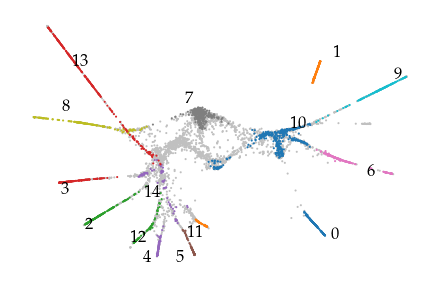

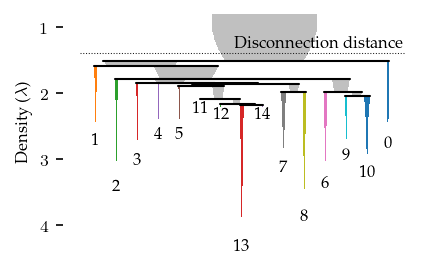

In [23]:
# Plot result
fig = sized_fig(1 / 2)
graph = c.cluster_approximation_graph_
graph.plot(positions=X2, node_color="cluster_label", node_size=1, edge_width=0)
label_groups(X2, c.cluster_labels_)
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("./images/elegans_clusters.pdf", pad_inches=0)
plt.show()

fig = sized_fig(1 / 2)
c.condensed_tree_.plot(leaf_separation=0.2, label_clusters=True)
plt.hlines(1 / dist_threshold, *plt.xlim(), "k", linestyles=":", lw=0.5)
plt.ylim(plt.ylim()[0], 0.8)
plt.text(
    plt.xlim()[1] * 0.95,
    1 / dist_threshold,
    "Disconnection distance",
    va="bottom",
    ha="right",
)
plt.subplots_adjust(0.13, 0.1, 1, 0.95)
plt.ylabel("Density ($\\lambda$)")
plt.savefig("./images/elegans_clusters_hierarchy.pdf", pad_inches=0)
plt.show()

## Branches

The branch hierarchy is extracted by first embedding the data into 3D using
UMAP. This is a denoising step that supresses noisy points and connections and
expresses the strongest connectivity in 3D coordinates. Using 3 dimensions
avoids crossings that are more likely in 2D. In addition, we use a ramping
repulsion strategy that first moves connected points close together, then
separates the structures, and finally lets connected structures move closer
together again. Care needs to be taken that the 3D embedding properly converges and does not introduce gaps or overlaps between structures.

FLASC is then configured to interpret the data as a single cluster and detect
the branch hierarchy using the core graphs and leaf strategy.

In [24]:
# Embed down to 3D
p.n_components = 3
del p.embedding_
p = lu.embed_graph(
    p, repulsion_strengths=[0.01, 0.1, 0.3, 0.03], epoch_sequence=[400, 300, 300, 200]
)

In [25]:
# Run FLASC on 3D embedding
c = FLASC(
    min_samples=3,
    min_branch_size=50,
    min_cluster_size=500,
    allow_single_cluster=True,
    branch_detection_method="core",
    branch_selection_method="leaf",
).fit(p.embedding_)
graph = c.cluster_approximation_graph_
# Geodesic labels
# labels, branch_labels = update_labels_with_branch_centrality(c, branch_centrality_vectors(c))

The resulting hierarchy more closely resembles the data's shape, ignoring some spurrious connections that would be detected when FLASC operates on the pre-processed data.

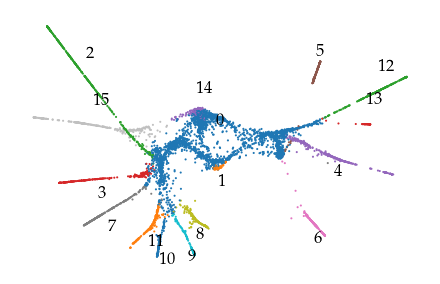

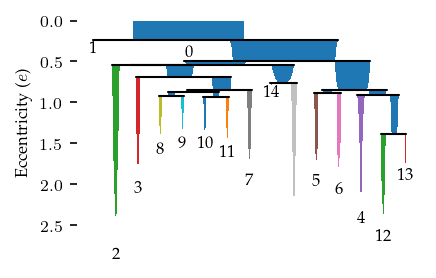

In [26]:
# Plot result
fig = sized_fig(1 / 2)
cmap = plt.colormaps["tab10"].colors
_labels = c.labels_.copy()
for pts in c.cluster_points_:
    if np.any(c.branch_labels_[pts] > 0):
        _labels[_labels == _labels[pts].max()] = -1
colors = np.asarray(
    [cmap[l % 10] if l >= 0 else mpl.colors.to_rgb("silver") for l in _labels]
)
graph.plot(
    positions=X2,
    node_color=colors,
    node_cmap=None,
    node_size=1,
    edge_width=0,
)
label_groups(X2, c.labels_, x_offset=0, y_offset=0.3)
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig("./images/elegans_branch_embedding.pdf", pad_inches=0)
plt.show()

fig = sized_fig(1 / 2)
c.branch_condensed_trees_[-1].plot(
    leaf_separation=0.2, label_clusters=True, color_centre_as_noise=True
)
plt.subplots_adjust(0.16, 0.14, 1, 0.95)
plt.ylabel("Eccentricity ($e$)")
plt.savefig("./images/elegans_branch_hierarchy_embedding.pdf", pad_inches=0)
plt.show()